In [1]:
# import some modules and read in the dataset
import pandas as pd
from tensorflow import keras
import numpy as np
import math
path = 'winemag-data-130k-v2.csv'  # ADD path/to/dataset
data = pd.read_csv(path)
data = data.sample(frac=1., random_state=42)
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
77718,77718,Australia,"Possibly a little sweet, this is a soft, easyg...",NaN,83,5.0,Australia Other,South Eastern Australia,NaN,Joe Czerwinski,@JoeCz,Banrock Station 2006 Chardonnay (South Eastern...,Chardonnay,Banrock Station
67681,67681,France,"A soft, almost off dry wine that is full in th...",Réserve,85,12.0,Rhône Valley,Côtes du Rhône,NaN,Roger Voss,@vossroger,Cellier des Dauphins 2015 Réserve Rosé (Côtes ...,Rosé,Cellier des Dauphins
69877,69877,Spain,Generic white-fruit aromas of peach and apple ...,Estate Grown & Bottled,86,9.0,Northern Spain,Rueda,NaN,Michael Schachner,@wineschach,Esperanza 2013 Estate Grown & Bottled Verdejo-...,Verdejo-Viura,Esperanza
46544,46544,US,This is the winery's best Nebula in years. Whi...,Nebula,87,29.0,California,Paso Robles,Central Coast,NaN,NaN,Midnight 2010 Nebula Cabernet Sauvignon (Paso ...,Cabernet Sauvignon,Midnight
186,186,US,This is a very rich Pinot whose primary virtue...,Wiley Vineyard,88,40.0,California,Anderson Valley,NaN,NaN,NaN,Harrington 2006 Wiley Vineyard Pinot Noir (And...,Pinot Noir,Harrington


In [2]:
# Clean it from null values
data = data[pd.notnull(data['country'])]
data = data[pd.notnull(data['price'])]
data = data.drop(data.columns[0], axis=1) 
variety_threshold = 500 # Anything that occurs less than this will be removed.
value_counts = data['variety'].value_counts()
to_remove = value_counts[value_counts <= variety_threshold].index
data.replace(to_remove, np.nan, inplace=True)
data = data[pd.notnull(data['variety'])]
data = data[pd.notnull(data['winery'])]

# Split data into train and test
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

# Train features
description_train = data['description'][:train_size]
variety_train = data['variety'][:train_size]

# Train labels
labels_train = data['price'][:train_size]

# Test features
description_test = data['description'][train_size:]
variety_test = data['variety'][train_size:]

# Test labels
labels_test = data['price'][train_size:]

x_train = description_train.values
y_train = labels_train.values
x_test = description_test.values
y_test = labels_test.values

# winery  metadata to be used later
winery_train = data['winery'][:train_size]
winery_test = data['winery'][train_size:]

Train size: 82412
Test size: 20604


In [ ]:
!pip install ktrain

In [6]:
import ktrain
from ktrain import text

In [7]:
trn, val, preproc = text.texts_from_array(x_train=x_train, y_train=y_train,
                                          x_test=x_test, y_test=y_test,
                                          ngram_range=3, 
                                          maxlen=200, 
                                          max_features=35000)

language: en
Word Counts: 30449
Nrows: 82412
82412 train sequences
train sequence lengths:
	mean : 41
	95percentile : 61
	99percentile : 73
Adding 3-gram features
max_features changed to 1895330 with addition of ngrams
Average train sequence length with ngrams: 121
train (w/ngrams) sequence lengths:
	mean : 121
	95percentile : 180
	99percentile : 216
x_train shape: (82412,200)
y_train shape: (82412,)


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:607: UserWarning: Task is being treated as REGRESSION because either class_names argument was not supplied or is_regression=True. If this is incorrect, change accordingly.
  'either class_names argument was not supplied or is_regression=True. ' + \


20604 test sequences
test sequence lengths:
	mean : 41
	95percentile : 61
	99percentile : 73
Average test sequence length with ngrams: 105
test (w/ngrams) sequence lengths:
	mean : 105
	95percentile : 156
	99percentile : 185
x_test shape: (20604,200)
y_test shape: (20604,)
task: text regression (supply class_names argument if this is supposed to be classification task)


In [8]:
text.print_text_regression_models()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
linreg: linear text regression using a trainable Embedding layer
bigru: Bidirectional GRU with pretrained English word vectors [https://arxiv.org/abs/1712.09405]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) - keras_bert implementation [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


In [9]:
model = text.text_regression_model('linreg', train_data=trn, preproc=preproc)

maxlen is 200
done.


In [10]:
extra_train_data = winery_train
extra_test_data = winery_test

# encode winery as integers
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(data['winery'])
extra_train = encoder.transform(extra_train_data)
extra_test = encoder.transform(extra_test_data)
no_of_unique_cat = np.max(extra_train) + 1
embedding_size = min(np.ceil((no_of_unique_cat)/2), 50 )
embedding_size = int(embedding_size)
vocab =  no_of_unique_cat+1
print(embedding_size)
extra_train = np.expand_dims(extra_train, -1)
extra_test = np.expand_dims(extra_test, -1)

# winery module
extra_input = keras.layers.Input(shape=(1,))
extra_output = keras.layers.Embedding(vocab, embedding_size, input_length=1)(extra_input)
extra_output = keras.layers.Flatten()(extra_output)
extra_model = keras.Model(inputs=extra_input, outputs=extra_output)
extra_model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Combine winery module with linreg model
merged_out = keras.layers.concatenate([extra_model.output, model.output])
merged_out = keras.layers.Dropout(0.25)(merged_out)
merged_out = keras.layers.Dense(1000, activation='relu')(merged_out)
merged_out = keras.layers.Dropout(0.25)(merged_out)
merged_out = keras.layers.Dense(500, activation='relu')(merged_out)
merged_out = keras.layers.Dropout(0.5)(merged_out)
merged_out = keras.layers.Dense(1)(merged_out)
combined_model = keras.Model([extra_model.input] + [model.input], merged_out)
combined_model.compile(loss='mae',
                       optimizer='adam',
                      metrics=['mae'])

50


In [25]:
winery_train

77718          Banrock Station
67681     Cellier des Dauphins
46544                 Midnight
186                 Harrington
73126                   Meiomi
                  ...         
108089         Domaine Laporte
108788          Santos & Seixo
35607              Betz Family
11408              Fess Parker
90253                    Pomum
Name: winery, Length: 82412, dtype: object

In [26]:
winery_test

22875                  Le Bonheur
103018                      Foris
114431             Markus Wine Co
116556           Pietro Beconcini
79382         Full Pull & Friends
                   ...           
119879         Hill Family Estate
128106    Weingut Liebfrauenstift
860                Gershon Bachus
15795             Chateau Margene
121958            Palazzo Vecchio
Name: winery, Length: 20604, dtype: object

In [11]:
class MyCustomDataset(ktrain.SequenceDataset):
    def __init__(self, x, y, batch_size=32, shuffle=True):
        # error checks
        err = False
        if type(x) == np.ndarray and len(x.shape) != 2: err = True
        elif type(x) == list:
            for d in x:
                if type(d) != np.ndarray or len(d.shape) != 2:
                    err = True
                    break
        else: err = True
        if err:
            raise ValueError('x must be a 2d numpy array or a list of 2d numpy arrays')
        if type(y) != np.ndarray:
            raise ValueError('y must be a numpy array')
        if type(x) == np.ndarray:
            x = [x]

        # set variables
        super().__init__(batch_size=batch_size)
        self.x, self.y = x, y
        self.indices = np.arange(self.x[0].shape[0])
        self.n_inputs = len(x)
        self.shuffle = shuffle

    # required for instances of tf.keras.utils.Sequence
    def __len__(self):
        return math.ceil(self.x[0].shape[0] / self.batch_size)

    # required for instances of tf.keras.utils.Sequence
    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = []
        for i in range(self.n_inputs):
            batch_x.append(self.x[i][inds])
        batch_y = self.y[inds]
        return tuple(batch_x), batch_y

    # required for instances of ktrain.Dataset
    def nsamples(self):
        return self.x[0].shape[0]

    #required for instances of ktrain.Dataset
    def get_y(self):
        return self.y

    def on_epoch_end(self):
        if self.shuffle:  np.random.shuffle(self.indices)

In [18]:
len(trn)

2

In [21]:
len(np.unique(trn[1]))

351

In [12]:
train_data = MyCustomDataset([extra_train] +  [trn[0]], trn[1], shuffle=True)
val_data = MyCustomDataset([extra_test] + [val[0]], val[1], shuffle=False)
learner = ktrain.get_learner(combined_model, train_data=train_data, val_data=val_data, batch_size=256)

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
321/321 [==============================] - 20s 59ms/step - loss: 36.5969 - mae: 36.5969
Epoch 2/1024
321/321 [==============================] - 19s 59ms/step - loss: 35.2003 - mae: 35.2003
Epoch 3/1024
321/321 [==============================] - 19s 59ms/step - loss: 16.8286 - mae: 16.8286
Epoch 4/1024
321/321 [==============================] - 19s 59ms/step - loss: 14.3256 - mae: 14.3256
Epoch 5/1024
321/321 [==============================] - 19s 59ms/step - loss: 30.4814 - mae: 30.4814
Epoch 6/1024
321/321 [==============================] - 15s 46ms/step - loss: 20.6723 - mae: 20.6723


done.
Visually inspect loss plot and select learning rate associated with falling loss


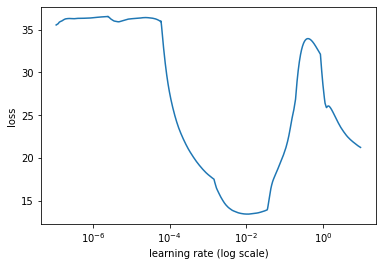

In [22]:
learner.lr_find(show_plot=True, restore_weights_only=True)

In [23]:
learner.fit_onecycle(1e-3, 12)



begin training using onecycle policy with max lr of 0.001...
Epoch 1/12
322/322 [==============================] - 21s 66ms/step - loss: 26.0577 - mae: 26.0577 - val_loss: 15.1405 - val_mae: 15.1405
Epoch 2/12
322/322 [==============================] - 21s 65ms/step - loss: 14.2357 - mae: 14.2357 - val_loss: 12.1571 - val_mae: 12.1571
Epoch 3/12
322/322 [==============================] - 21s 65ms/step - loss: 11.5527 - mae: 11.5527 - val_loss: 11.6031 - val_mae: 11.6031
Epoch 4/12
322/322 [==============================] - 21s 64ms/step - loss: 10.3835 - mae: 10.3835 - val_loss: 11.1915 - val_mae: 11.1915
Epoch 5/12
322/322 [==============================] - 21s 64ms/step - loss: 9.6797 - mae: 9.6797 - val_loss: 11.0828 - val_mae: 11.0828
Epoch 6/12
322/322 [==============================] - 21s 64ms/step - loss: 9.1562 - mae: 9.1562 - val_loss: 11.0817 - val_mae: 11.0817
Epoch 7/12
322/322 [==============================] - 21s 65ms/step - loss: 8.8013 - mae: 8.8013 - val_loss: 10.8